# Query-by-Example (QbE) Search Using DTW

## Preliminary

First download the following example audio files into the current directory (`example/`):

    wget www.kamperh.com/data/speech_dtw_qbe_wav.zip
    unzip speech_dtw_qbe_wav.zip

The file `wav/query.wav` will be used as our query, while `wav/search?.wav` is our search collection.

In [105]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
from __future__ import division
from __future__ import print_function
from os import path
from python_speech_features import delta
from python_speech_features import mfcc
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
import sys

sys.path.append("..")
sys.path.append(path.join("..", "utils"))

from speech_dtw import qbe

## Extract features

In [107]:
def get_mfcc_dd(wav_fn, cmvn=True):
    """Return the MFCCs with deltas and delta-deltas for a audio file."""
    (rate, signal) = wav.read(wav_fn)
    mfcc_static = mfcc(signal, rate)
    mfcc_deltas = delta(mfcc_static, 2)
    mfcc_delta_deltas = delta(mfcc_deltas, 2)
    features = np.hstack([mfcc_static, mfcc_deltas, mfcc_delta_deltas])
    if cmvn:
        features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    return features

In [108]:
wav_fn = path.join("wav", "query.wav")
print("Reading:", wav_fn)
query_mfcc = get_mfcc_dd(wav_fn)
search_mfcc_list = []
for wav_fn in sorted(glob.glob(path.join("wav", "search?.wav"))):
    print("Reading:", wav_fn)
    search_mfcc_list.append(get_mfcc_dd(wav_fn))

Reading: wav/query.wav
Reading: wav/search1.wav
Reading: wav/search2.wav
Reading: wav/search3.wav
Reading: wav/search4.wav


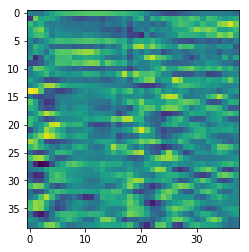

In [109]:
# Plot query
plt.imshow(query_mfcc.T, interpolation="nearest")

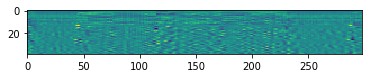

In [115]:
# Plot search utterance
plt.imshow(search_mfcc_list[0].T, interpolation="nearest")

## Intermediate analysis

Align query to a search utterance from the same speaker containing the keyword.

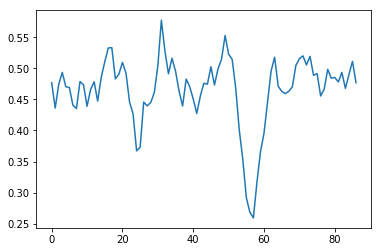

In [110]:
sweep = qbe.dtw_sweep(query_mfcc, search_mfcc_list[0])
plt.plot(sweep)

The minimum aligns with the occurrence of the keyword.

Align query to search utterance from same speaker not containing the keyword.

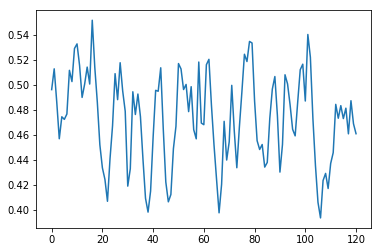

In [111]:
sweep = qbe.dtw_sweep(query_mfcc, search_mfcc_list[2])
plt.plot(sweep)

Here we do not see any dips over the swept scores.

## QbE experiments

Of the four utterances in the search collection, only the utterance `wav/search3.wav` does not contain the keyword. This element corresponds to `search_mfcc_list[2]`.

In [112]:
# Calculate the scores manually
dtw_costs = []
for search_mfcc in search_mfcc_list:
    dtw_costs.append(qbe.dtw_sweep_min(query_mfcc, search_mfcc))
print("DTW costs over search collection:", dtw_costs)

DTW costs over search collection: [0.25932766480105984, 0.3731169396110413, 0.3933897222434943, 0.3343819460775823]


In [117]:
# Calculate the scores using the parallelised implementation
n_cpus = 4
dtw_costs = qbe.parallel_dtw_sweep_min([query_mfcc], search_mfcc_list, n_cpus=n_cpus)
print("DTW costs over search collection:", dtw_costs[0])

DTW costs over search collection: [0.25932766480105984, 0.3731169396110413, 0.3933897222434943, 0.3343819460775823]


At a threshold of 0.38, our system is therefore 100% accurate. However, the score for `search_mfcc_list[1]` is misleading: considering the alignment curve for this utterance with the query, this low score is actually obtained at a completely irrelevant position.

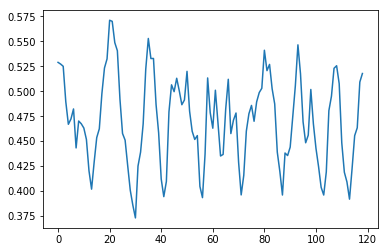

In [114]:
sweep = qbe.dtw_sweep(query_mfcc, search_mfcc_list[1])
plt.plot(sweep)

This search utterance is actually from a female speaker, which makes the alignment less predictable.